In [1]:
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
%matplotlib inline

# import some common libraries
import torch
import tifffile as tiff
import numpy as np
import cv2
from pathlib import Path
import shutil

from PIL import Image
from detectron2.structures import BoxMode
from tqdm import tqdm
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import os
from natsort import natsorted
from IPython.display import clear_output
import time
import sys



In [48]:
imSource = r'F:\Work\UNI\ResProj\TR-Y4-Project\Image_repo\t_1_MMStack_Default_6.ome.tif'
images = cv2.imreadmulti(imSource)[1][::2]
print(images)

(array([[26, 29, 25, ..., 23, 24, 29],
       [28, 30, 23, ..., 24, 25, 27],
       [25, 31, 29, ..., 27, 26, 23],
       ...,
       [23, 24, 25, ..., 26, 23, 26],
       [28, 26, 26, ..., 26, 24, 28],
       [27, 26, 22, ..., 21, 25, 27]], dtype=uint8), array([[27, 28, 26, ..., 23, 26, 26],
       [23, 27, 24, ..., 24, 27, 25],
       [27, 27, 29, ..., 28, 24, 26],
       ...,
       [29, 24, 24, ..., 26, 25, 24],
       [23, 27, 24, ..., 26, 27, 28],
       [24, 23, 23, ..., 26, 26, 26]], dtype=uint8), array([[26, 25, 28, ..., 24, 26, 27],
       [25, 25, 27, ..., 22, 27, 25],
       [29, 21, 26, ..., 23, 25, 25],
       ...,
       [23, 29, 29, ..., 27, 23, 21],
       [25, 26, 25, ..., 22, 26, 26],
       [25, 25, 26, ..., 23, 25, 26]], dtype=uint8), array([[22, 25, 25, ..., 28, 23, 24],
       [24, 25, 25, ..., 24, 24, 29],
       [24, 29, 26, ..., 26, 26, 21],
       ...,
       [28, 23, 25, ..., 23, 26, 24],
       [24, 25, 29, ..., 24, 27, 29],
       [27, 30, 24, ..., 21, 23,

In [52]:
print(images[50])

[[12  9  9 ... 23 23 23]
 [10 12 14 ... 25 21 26]
 [11 10 12 ... 23 21 24]
 ...
 [65 65 57 ... 27 33 30]
 [70 64 62 ... 34 30 33]
 [67 68 60 ... 32 27 31]]


In [53]:
c = np.stack([images[0], images[0], images[0]])

In [54]:
c = c.transpose(1, 2, 0)
print(c.shape)

(3648, 5472, 3)


In [2]:
imSource = r'F:\Work\UNI\ResProj\TR-Y4-Project\Image_repo\t_1_MMStack_Default_6.ome.tif'
images = tiff.imread(imSource)
Dataset = np.float32(np.array([phase[0] for phase in images]))

<tifffile.TiffFile 't_1_MMStack_Default_6.ome.tif'> MMStack series is missing files. Returning subset (107, 1, 1, 2) of (1200, 1, 1, 2)


In [3]:
norm = Dataset.min()/Dataset.max()
Dataset -= norm

In [3]:
print(Dataset)

[[[26. 29. 25. ... 23. 24. 29.]
  [28. 30. 23. ... 24. 25. 27.]
  [25. 31. 29. ... 27. 26. 23.]
  ...
  [23. 24. 25. ... 26. 23. 26.]
  [28. 26. 26. ... 26. 24. 28.]
  [27. 26. 22. ... 21. 25. 27.]]

 [[27. 28. 26. ... 23. 26. 26.]
  [23. 27. 24. ... 24. 27. 25.]
  [27. 27. 29. ... 28. 24. 26.]
  ...
  [29. 24. 24. ... 26. 25. 24.]
  [23. 27. 24. ... 26. 27. 28.]
  [24. 23. 23. ... 26. 26. 26.]]

 [[26. 25. 28. ... 24. 26. 27.]
  [25. 25. 27. ... 22. 27. 25.]
  [29. 21. 26. ... 23. 25. 25.]
  ...
  [23. 29. 29. ... 27. 23. 21.]
  [25. 26. 25. ... 22. 26. 26.]
  [25. 25. 26. ... 23. 25. 26.]]

 ...

 [[21. 25. 23. ... 26. 23. 24.]
  [29. 21. 23. ... 22. 20. 23.]
  [23. 24. 25. ... 23. 21. 23.]
  ...
  [28. 26. 23. ... 30. 32. 32.]
  [24. 25. 24. ... 33. 30. 33.]
  [22. 23. 23. ... 30. 33. 28.]]

 [[23. 28. 23. ... 23. 24. 25.]
  [25. 27. 23. ... 21. 20. 18.]
  [23. 26. 27. ... 23. 20. 25.]
  ...
  [25. 25. 24. ... 31. 33. 30.]
  [26. 27. 26. ... 27. 30. 31.]
  [25. 26. 24. ... 29. 28. 3

In [5]:
Dataset *= 255

In [4]:
print('training set shape', Dataset.shape)
print('training set max', Dataset.max())

training set shape (107, 3648, 5472)
training set max 255.0


In [20]:
img = Dataset[2]

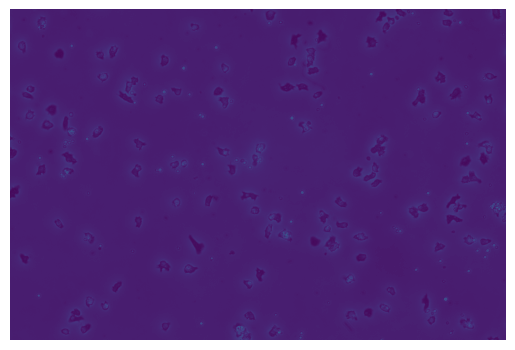

In [8]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training
cfg.MODEL.WEIGHTS = r"F:\Work\UNI\ResProj\TR-Y4-Project\Model_v2\model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # We have 200 classes.
cfg.TEST.DETECTIONS_PER_IMAGE = 300
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/27 09:22:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from F:\Work\UNI\ResProj\TR-Y4-Project\Model_v2\model_final.pth ...


In [21]:
import torchvision.transforms as transforms
img = Image.fromarray(img)
# image to a Torch tensor

transform = transforms.Compose([
    transforms.PILToTensor()
])


img = transform(img)

print(img)

tensor([[[26., 25., 28.,  ..., 24., 26., 27.],
         [25., 25., 27.,  ..., 22., 27., 25.],
         [29., 21., 26.,  ..., 23., 25., 25.],
         ...,
         [23., 29., 29.,  ..., 27., 23., 21.],
         [25., 26., 25.,  ..., 22., 26., 26.],
         [25., 25., 26.,  ..., 23., 25., 26.]]])


In [24]:
print(cv2.imread(img))

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imread'
> Overload resolution failed:
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object


In [ ]:
# input_images_directory = Dataset
output_directory = 'Phase_masks_Tiff'

if os.path.exists(output_directory): # if folder phase masks already exists in output directory remakes
    shutil.rmtree(output_directory)
    
    
os.makedirs(output_directory) # Makes new phase masks dir

# dirFiles = os.listdir(input_images_directory)
# dirFiles = natsorted(dirFiles)
# num_images = len(dirFiles)
# print(dirFiles)


#dirFiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

classes = ["amoeba", "yeast"]

for i, image in enumerate(images):
    sys.stdout.write(f'\rSegmenting image {i + 1} / {len(images)}')
    sys.stdout.flush()

    image_filename = "phase_" + str(i)

    image = np.stack([image,image,image])

    outputs = predictor(image.transpose(1, 2, 0)) # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.int16, )
                   for class_name in classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = classes[pred_class]
        instance_mask = outputs["instances"].pred_masks[i]
        class_masks[class_name] = torch.where(instance_mask,
                                              torch.tensor(i + 1, dtype=torch.float32),
                                              class_masks[class_name].to(dtype=torch.float32))
        class_masks[class_name] = class_masks[class_name].to(dtype=torch.int16)

    for class_name, class_mask in class_masks.items():
        class_mask_np = class_mask.cpu().numpy()
        image_name = image_filename + f'_{class_name}.tif'

        output_path = os.path.join(output_directory, class_name)
        os.makedirs(output_path, exist_ok=True)

        Image.fromarray(class_mask_np.astype(np.uint16)).save(Path(output_path) / image_name)

Segmenting image 107 / 107

: 